In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-14 09:36:48.270405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 09:36:48.273975: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 09:36:48.284891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752478608.302942  572736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752478608.308444  572736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 09:36:48.327410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

with open('../models/ResNet18_config.json') as f:
    config = json.load(f)
model = model_from_json(config)
model.load_weights("../models/ResNet18.weights.json")

# model = load_model("../models/ResNet18.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-14 09:36:51.199007: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/scratch/aaki/envs/ml/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 166 variables whereas the saved optimizer has 147 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 121s 85ms/step - accuracy: 0.9899 - loss: 0.0434
Test Accuracy: 0.9926
Test Loss: 0.0307


In [4]:
# Shuffle needs to be off for this to make sense

y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 119s 84ms/step


In [10]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.995]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 70057 predictions greater then 0.5

69986 predictions are greater then 0.6
That is 99.9 percent of all predictions greater then 0.5

69886 predictions are greater then 0.7
That is 99.8 percent of all predictions greater then 0.5

69782 predictions are greater then 0.8
That is 99.6 percent of all predictions greater then 0.5

69580 predictions are greater then 0.9
That is 99.3 percent of all predictions greater then 0.5

69350 predictions are greater then 0.95
That is 99.0 percent of all predictions greater then 0.5

68992 predictions are greater then 0.98
That is 98.5 percent of all predictions greater then 0.5

68353 predictions are greater then 0.995
That is 97.6 percent of all predictions greater then 0.5


In [6]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 19943 predictions less then 0.5

19869 predictions are smaller then 0.4
That is 99.6 percent of all predictions smaller then 0.5

19793 predictions are smaller then 0.3
That is 99.2 percent of all predictions smaller then 0.5

19711 predictions are smaller then 0.2
That is 98.8 percent of all predictions smaller then 0.5

19594 predictions are smaller then 0.1
That is 98.3 percent of all predictions smaller then 0.5

19488 predictions are smaller then 0.05
That is 97.7 percent of all predictions smaller then 0.5

19333 predictions are smaller then 0.02
That is 96.9 percent of all predictions smaller then 0.5


In [7]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.98      0.98      0.98     20000
    ImageNet       0.99      1.00      1.00     70000

    accuracy                           0.99     90000
   macro avg       0.99      0.99      0.99     90000
weighted avg       0.99      0.99      0.99     90000



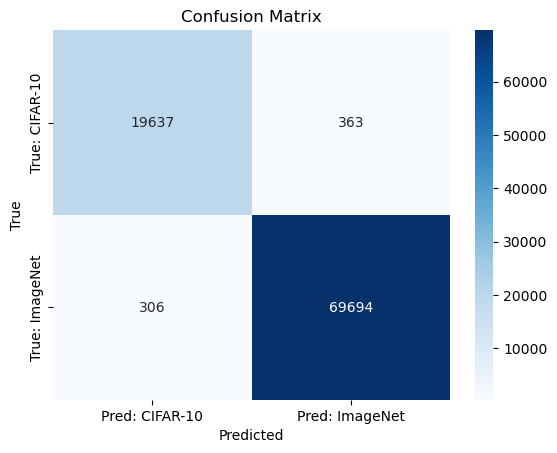

In [8]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()